# Lab Deep Learning / Multi-Layer Perceptron for regression / in pytorch

Lab session recap : A.C.

## Objective:

The objective of this lab is to demonstrate the use of Neural Networks to perform non-linear regression.
We will use a simple NN with 1 hidden layer. The hidden layer has $n_h$ (you will test various values of $n_h$) hidden units and either a ```sigmoid```, ```relu``` or ```tanh``` activation.
Since we perform a regression task the output $\hat{y} \in \mathbb{R}$ and  there is no output activation (linear).

You will perform 1000 iterations (epochs) of SGD to find the parameters.

You will then apply the network to the two datasets A and B.

Note: for this lab, we do not separate the dataset into a train, validation and test part. We simply check the ```capacity``` of the network to model the training data.

**Question**: according to the obtained loss, discuss the choice of ```sigmoid```, ```relu``` or ```tanh```.



### Data normalization

You should normalize the data to zero mean and unit standard deviation

### Model

There are various ways to write a NN model in pytorch.

In this lab, you will write three different implementations:
- **Model A**: manually defining the parameters (W1,b1,W2,b2), writting the forward equations, writting the loss equation, calling the .backward() and manually updating the weights using W1.grad. You will write the loop to perform 1000 epochs.
- **Model B**: using the Sequential class of pytorch
- **Model C**: a custom torch.nn.Module class for this.

For Model B and C, you will use the ready made loss and optimization from the nn and optim packages. You can use the same code to optimize the parameters of Model B and C.

### Loss

Since we are dealing with a regression problem, we will use a Mean Square Error loss: write it by-hand for Model A and use ```torch.nn.MSELoss``` for Model B and C.

### Parameters update/ Optimization

For updating the parameters, we will use as optimizer a simple SGD algorithm (use ```torch.optim.SGD``` for Model B and C) with a learning rate of 0.05.

Don't forget that an optimizer is applied to a set of parameters (```my_model.parameters()``` gives the parameters of the network for Model B and C).
Once the gradients have been computed (after the backpropagation has been performed), you can perform one step of optimization (using ```optimizer.step()``` for Model B and C).

### Backward propagation

Backpropagation is automatically performed in pytorch using the ```autograd``` package.
First, reset the gradients of all parameters (using ```optimizer.zero_grad()``` for Model B and C), then perform the backpropagation ```loss.backward()```.

### Regularization

- How can you add a Ridge (L2) regularization ? this can be done easely within the definition of the ```optimizer```.
- How can you add a Lasso (L1) regularization ? this has to be done manually at each iteration, by adding something to the loss before backpropagation.

**Question**: discuss the use of the Ridge and Lasso regularization for each dataset.

## Load the python packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

## Datasets

We will use two different datasets. For both $x$ has dimensions $(m,n_{in}=1)$ and $y$ has dimensions $(m,n_{out}=1)$ where $m$ is the number of examples.



In [2]:
def F_do_dataset_parab(m):
    x_data = torch.linspace(-1, 1, m)
    noise_data = 0.2*torch.rand(m)
    y_data = x_data.pow(2) + noise_data

    # Vectors to matrix
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1)
    return x_data, y_data

def F_do_dataset_sin(m):
    x_data = torch.arange(0, m, dtype=torch.float32)
    noise_data = 0.2*torch.rand(m)
    y_data = torch.sin(2*np.pi*x_data*0.001) + noise_data

    # Vectors to matrix
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1)
    return x_data, y_data

size of x_data: torch.Size([3000, 1])
size of y_data: torch.Size([3000, 1])


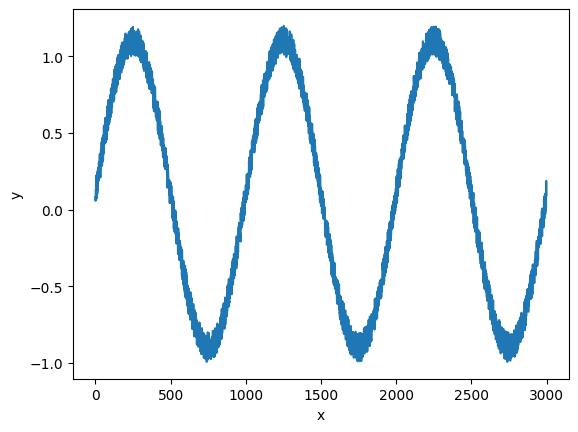

In [3]:
# --- Dataset 1
#x_data, y_data = F_do_dataset_parab(m=3000)
# --- Dataset 2
x_data, y_data = F_do_dataset_sin(m=3000)

plt.plot(x_data.numpy(), y_data.numpy())
plt.xlabel('x'),
plt.ylabel('y')

print('size of x_data:', x_data.size())
print('size of y_data:', y_data.size())

## Data standardization

We standardize the input data (substract mean and divide by standard-deviation)

In [ ]:
x_data = (x_data - x_data.mean())/x_data.std()
y_data = (y_data - y_data.mean())/y_data.std()

## Hyper-parameters definition

In [5]:
n_in = 1
n_h = 10
n_out = 1

nb_epoch = 20000
learning_rate_alpha = 0.05
param_momentum = 0.01
param_L1_weight = 0.001
param_L2_weight = 0.01

## Model A (writting the network equations)

For model A, you will define the variables and write the equations of the network yourself (as you would do in numpy).
However you will use ```torch tensors``` instead of ```numpy array```.

***Why ?*** because torch tensors will allows you to automatically get the gradient. You will use ```loss.backward()``` to launch the backpropagation from the ```loss``` variable.
Then, for all torch tensors you have created and for which you have declared ```requires_grad=True```, you will get the gradient of ```loss```with respect to this variable in the field ```.grad```.

***Example*** ```W1 = torch.tensors(..., requires_grad=True)``` ... ```loss.backward()``` will have the gradient $\frac{d Loss}{d W1}$ in ```W1.grad```.

### Initialize the variables

**Note**: In order to avoid neuron saturation and that all the neurons learn the same thing, the matrix should be initialized to a small random value (see https://pytorch.org/docs/stable/generated/torch.nn.Linear.html for details). Because of this, W1 and W2 should be first define as small random; **then** set to ```requires_grad=True```.

___

##### My justification

Since the model had difficulties training at first, and was stopping at 93% error, we assumed with the our lab session supervisor that it was an error of initialization.
Thus we applied standardization on every random vector and matrix we had so that this issue would disappear : then the model had a much better success rate (4% error).

In [ ]:
W1_init = torch.rand(n_h, n_in)*0.01 #We initialize the random matrix and then we standardize them
W1_init = (W1_init - W1_init.mean())/W1_init.std()

W1 = torch.tensor(W1_init , requires_grad = True) #We initialize our matrix with the correct dimension and with random values close to zero (but not zero)
b1 = torch.tensor(torch.rand(n_h), requires_grad = True)

W2_init = torch.rand(n_out, n_h)*0.01 #We initialize the random matrix and then we standardize them
W2_init = (W2_init - W2_init.mean())/W2_init.std()

W2 = torch.tensor(W2_init, requires_grad = True) #We initialize our matrix with the correct dimension and with random values close to zero (but not zero)
b2 = torch.tensor(torch.rand(n_out), requires_grad = True)

C:\Users\Arnaud\AppData\Local\Temp\ipykernel_14400\1434726820.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W1 = torch.tensor(W1_init , requires_grad = True) #We initialize our matrix with the correct dimension and with random values close to zero (but not zero)
C:\Users\Arnaud\AppData\Local\Temp\ipykernel_14400\1434726820.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b1 = torch.tensor(torch.rand(n_h), requires_grad = True)
C:\Users\Arnaud\AppData\Local\Temp\ipykernel_14400\1434726820.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(source

### Define the model

We will denote by ```H``` the results of the first projection, at pre-activation (value before the non-linearity) and by ```A``` the activation (value after the non-linearity).

___

### My justification

On page 83 on the course TSIA 207, we have the MLP model with 1 hidden layer.

In [ ]:
def model(X):
    H = X@W1.T+b1
    A = torch.tanh(H)
    y_pred = A@W2.T+b2
    return y_pred

### Train the model

**Note**: when updating the parameters (W1,b1,W2,b2) you should use an "in-place" update: ```W1 -= ...``` instead of ```W1 = W1 - ...```; otherwise ```W1``` will be replaced by its value and its gradient field will not exist anymore.

In [8]:
learning_rate_alpha=0.05

In [ ]:
for epoch in range(0, nb_epoch):
    # X (m, n_in)
    # Y (m, n_out)
    y_pred = model(x_data)
    loss = torch.mean(((y_pred-y_data)**2))
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss))
    loss.backward()
    with torch.no_grad():
        W1 -= learning_rate_alpha*W1.grad
        b1 -= learning_rate_alpha*b1.grad
        W2 -= learning_rate_alpha*W2.grad
        b2 -= learning_rate_alpha*b2.grad
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()

epoch 0, loss 2.410942792892456
epoch 1000, loss 0.2293189913034439
epoch 2000, loss 0.14249111711978912
epoch 3000, loss 0.13093383610248566
epoch 4000, loss 0.12049181759357452
epoch 5000, loss 0.11124479025602341
epoch 6000, loss 0.10290449857711792
epoch 7000, loss 0.09518866240978241
epoch 8000, loss 0.08799957484006882
epoch 9000, loss 0.08136436343193054
epoch 10000, loss 0.07533425092697144
epoch 11000, loss 0.06991972029209137
epoch 12000, loss 0.06508432328701019
epoch 13000, loss 0.06077222153544426
epoch 14000, loss 0.05693011358380318
epoch 15000, loss 0.05351394787430763
epoch 16000, loss 0.05048689618706703
epoch 17000, loss 0.047815266996622086
epoch 18000, loss 0.04546592757105827
epoch 19000, loss 0.04340535029768944


### Plotting the results

We will super-impose the biases of the first layer to better understand how the model has fit the sinusoidal curve. Please explain what it does.

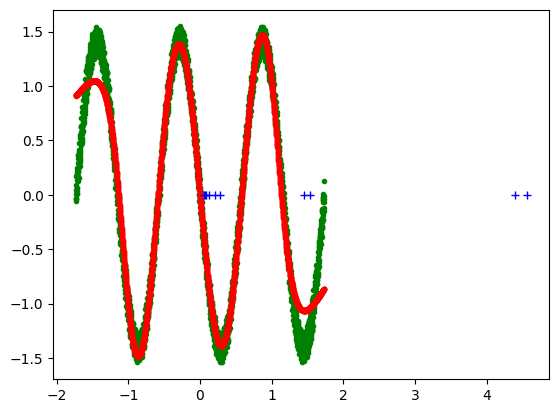

In [10]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g.')
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r.')
# super-impose the biases of the first layer
plt.plot(b1.detach().numpy(), np.zeros((10,1)), 'b+')

## Model B (using Sequential class)

Here, you will write the network using the nn.Sequential class.
With this you can use the ready-made layers ``torch.nn.Linear``,``torch.nn.Tanh``, ...

epoch 0, loss 1.3060369491577148
epoch 1000, loss 0.8823503255844116
epoch 2000, loss 0.6897628307342529
epoch 3000, loss 0.5849236845970154
epoch 4000, loss 0.4124024510383606
epoch 5000, loss 0.1016794815659523
epoch 6000, loss 0.07913383096456528
epoch 7000, loss 0.06908651441335678
epoch 8000, loss 0.060990627855062485
epoch 9000, loss 0.053572285920381546
epoch 10000, loss 0.046268291771411896
epoch 11000, loss 0.039028652012348175
epoch 12000, loss 0.032141897827386856
epoch 13000, loss 0.026026928797364235
epoch 14000, loss 0.02101030759513378
epoch 15000, loss 0.01718420535326004
epoch 16000, loss 0.014428941532969475
epoch 17000, loss 0.01251644641160965
epoch 18000, loss 0.011206606402993202
epoch 19000, loss 0.010302752256393433


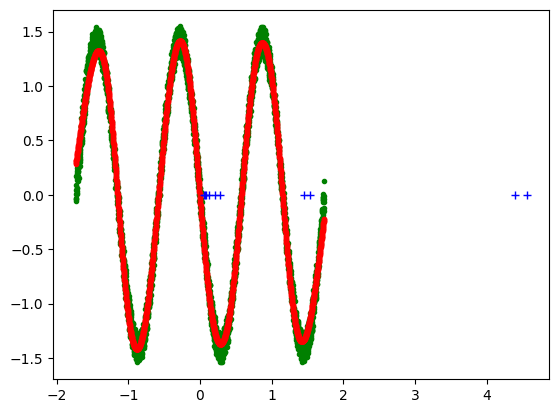

In [ ]:
model = nn.Sequential(
    nn.Linear(in_features=n_in, out_features=n_h),
    nn.Tanh(),
    nn.Linear(in_features=n_h, out_features=n_out)
)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate_alpha)

for epoch in range(nb_epoch):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(x_data.numpy(), y_data.numpy(), 'g.')
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r.')
plt.plot(b1.detach().numpy(), np.zeros((10,1)), 'b+')

#### My observation : We end up with a loss that is as low as model A, we get a satisfactory result.

## Model C (using a class definition)

Here, you will write the network using the recommended pytorch way; i.e. by defining a class.
This class inherit from the main class ```torch.nn.Module```.
You only need to write the ```__init__``` method and the ```forward``` method.

In object programming, the ```__init__``` method defines the attributes of your class. Since the attributes of your  network are the parameters to be trained (weights and biases), you should declare in the ```__init``` all the layers that involve parameters to be trained (mostly the ```Linear```layers which perform the matrix multiplication).

The ```forward``` method contains the code of the forward pass itself. It can of course call attributes defined in the ```__init___``` method. It is the method used when calling ```model(x)```.

As before, the model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```.

Classes are convenient way to write more complex network than what you can do with ```nn.sequential```. Note that you can actually include a ```nn.sequential``` in your class.

epoch 0, loss 0.9633446335792542
epoch 1000, loss 0.8554856777191162
epoch 2000, loss 0.7018361687660217
epoch 3000, loss 0.14793865382671356
epoch 4000, loss 0.1163342073559761
epoch 5000, loss 0.1058804839849472
epoch 6000, loss 0.09790875017642975
epoch 7000, loss 0.09142932295799255
epoch 8000, loss 0.08586911112070084
epoch 9000, loss 0.08044591546058655
epoch 10000, loss 0.07505027949810028
epoch 11000, loss 0.07024051994085312
epoch 12000, loss 0.06594385206699371
epoch 13000, loss 0.06205816566944122
epoch 14000, loss 0.05853160470724106
epoch 15000, loss 0.055313028395175934
epoch 16000, loss 0.05233103036880493
epoch 17000, loss 0.04948422312736511
epoch 18000, loss 0.04666903614997864
epoch 19000, loss 0.04387665167450905


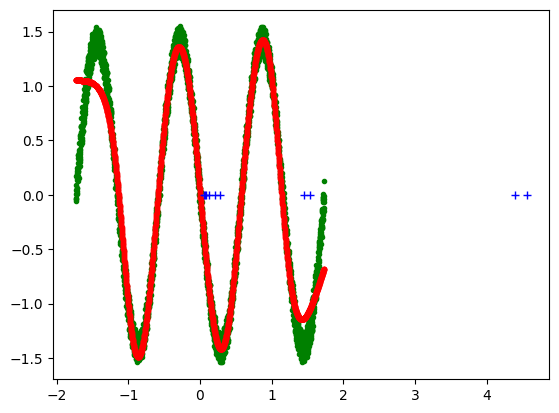

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_in = nn.Linear(n_in, n_h)
        self.tanh = nn.Tanh()
        self.linear_out = nn.Linear(n_h, n_out)

    def forward(self, x):
        h = self.linear_in(x)
        a = self.tanh(h)
        y_pred = self.linear_out(a)
        return y_pred

model = Net()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_alpha)
for epoch in range(0, nb_epoch):
	y_pred = model(x_data)
	loss = criterion(y_pred, y_data)
	if epoch % 1000 == 0:
		print('epoch {}, loss {}'.format(epoch, loss))
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()

plt.plot(x_data.numpy(), y_data.numpy(), 'g.')
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r.')
plt.plot(b1.detach().numpy(), np.zeros((10,1)), 'b+')

#### My observation : We end up with a loss that is as low as model A and B, we get a satisfactory result.

## Model B+C

### Criterion and Optimization

The code of Model A is self-contained, i.e. it already contains all necessary instruction to perform forward, loss, backward and parameter updates.

When using ```nn.sequential``` (model B) or a class definition of the network (model C), we still need to define
- what we will minimize (the loss to be minimized, i.e. Mean-Square-Error or Binary-Cross-Entropy). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)
- how we will minimize the loss, i.e. what parameter update alogirhtms we will use (SGD, momentum). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)

L2 regularization can be done directly in the optimizer under the name ```weight_decay```.

In [ ]:
model = nn.Sequential(
    nn.Linear(n_in, n_h),
    nn.Tanh(),
    nn.Linear(n_h, n_out)
)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate_alpha, weight_decay=0)

### Training

Having defined the network, the citerion to be minimized and the optimizer, we then perform a loop over epochs (iterations); at each step we
- compute the forward pass by passing the data to the model: ```haty = model(x)```
- compute the the loss (the criterion)
- putting at zero the gradients of all the parameters of the network (this is important since, by default, pytorch accumulate the gradients over time)
- computing the backpropagation (using as before ```.backward()```)
- performing one step of optimization (using ```.step()```)

In [ ]:
loss_l = []
for epoch in range(nb_epoch):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_l.append(loss)
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.data))

epoch 0, loss 1.0072681903839111
epoch 1000, loss 0.8230559229850769
epoch 2000, loss 0.6281745433807373
epoch 3000, loss 0.17380820214748383
epoch 4000, loss 0.10833998769521713
epoch 5000, loss 0.08708419650793076
epoch 6000, loss 0.07380566745996475
epoch 7000, loss 0.06424597650766373
epoch 8000, loss 0.05635751411318779
epoch 9000, loss 0.04930039867758751
epoch 10000, loss 0.04267032444477081
epoch 11000, loss 0.03632495179772377
epoch 12000, loss 0.030345484614372253
epoch 13000, loss 0.024962367489933968
epoch 14000, loss 0.02043735235929489
epoch 15000, loss 0.01691332459449768
epoch 16000, loss 0.014336948283016682
epoch 17000, loss 0.012526382692158222
epoch 18000, loss 0.01127407792955637
epoch 19000, loss 0.010403595864772797


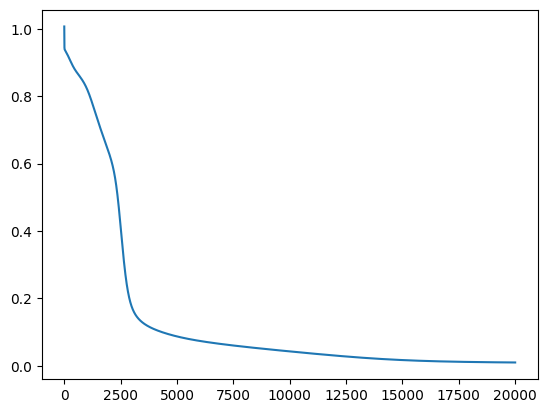

In [17]:
# ----------------
plt.plot([loss.detach().numpy() for loss in loss_l])

### Plotting results

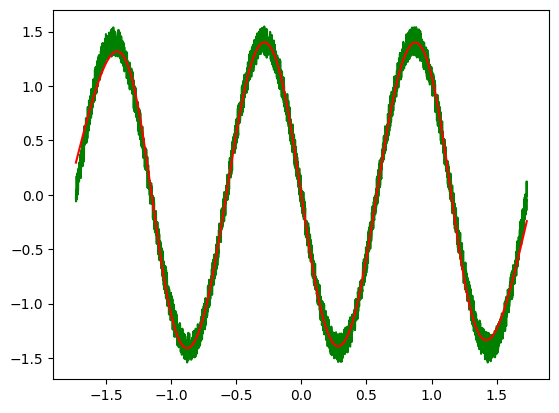

In [18]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g')
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r')

#### My observation : We end up with a loss that is really low, and the model fits really well teh sine curve, which is highly satisfactory. This is the best method so far.

### Display the weights and the biases

Now, we want to check the effect of L1 regularization. For this you will plot the values of the weights of each layers.

[[-3.719945  ]
 [ 1.9642705 ]
 [-0.5536247 ]
 [-1.4869254 ]
 [-3.4239764 ]
 [-3.7873712 ]
 [-3.661392  ]
 [-1.7227086 ]
 [-3.8277285 ]
 [-0.54046667]]
[ 0.00832222  0.67577887 -0.39700723 -2.3656218  -1.8813498   4.396247
  2.0883632   2.832507   -4.404331   -0.51164746]
[[ 2.4637437 -1.1372122 -0.6640893 -2.9250638 -2.4411159  3.2486672
  -2.0483787 -3.2765868  3.4109137 -2.0247815]]
[-0.36124864]


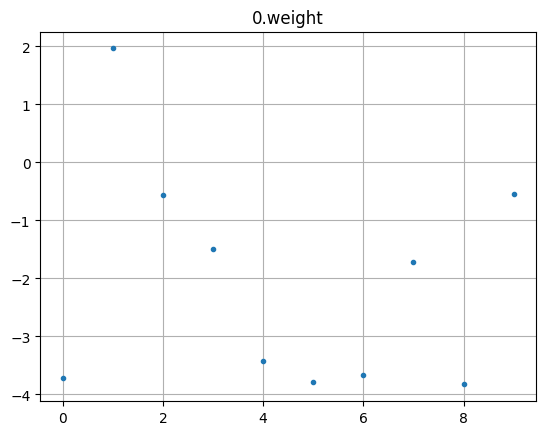

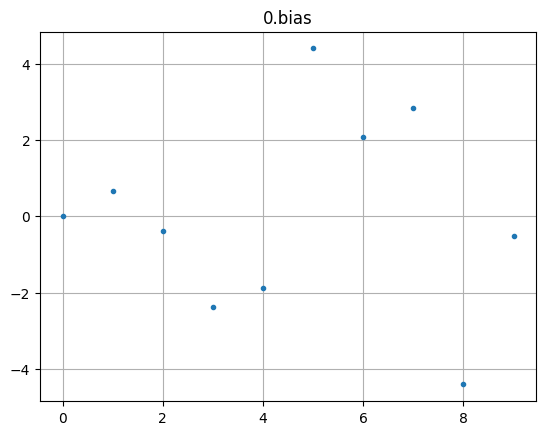

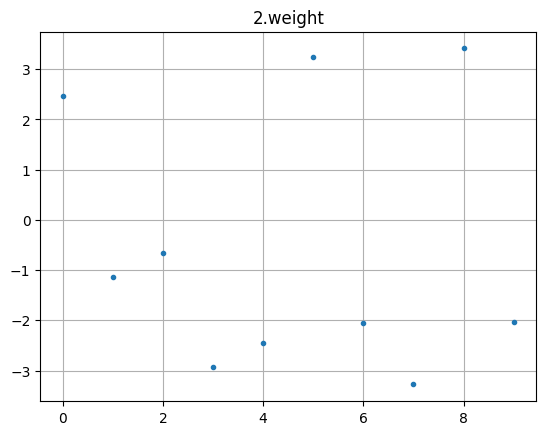

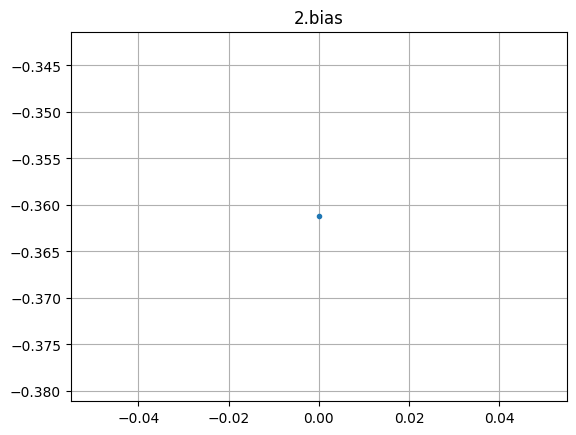

In [19]:
list_l = [{'name':name, 'data':layer.data} for name, layer in model.named_parameters()]
for tmp in list_l:
    plt.figure()
    plt.plot(tmp['data'].flatten().numpy(), '.')
    plt.title(tmp['name'])
    plt.grid(True)
    print(tmp['data'].numpy())

#### Every part of this computer lab session works smoothly, the results are satisfactory. We have correctly trained the models for each part A, B, C, and B/C.